In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools 

import os
ROOT = os.popen("git rev-parse --show-toplevel").read().split("\n")[0]

import sys
sys.path.append(ROOT)

import src as sc

# Prepare Campus Data

The cell below can also be carried out in one step by running 
```
> python src/preprocessing.py
> python src/locations.py 
```
from the top level git directory.

In [2]:
# One-hot table with halls as rows and schools as columns.
hall_df = sc.get_hall_by_school_table()

# Dataframe with one row per enrolled student.
student_df = sc.get_student_enrollment_data()

# Proportionally assigns students to buildings, writing
# student dataframes to csv as:
#      "../data/filled_buildings/<building_name>_students.csv"

sc.fill_buildings(student_df = student_df, hall_df = hall_df)


INFO:root:
 Filling residence halls...
INFO:root:
 Filling remaining buildings...


# Compute Cost & Assignment Matrix

The cell below can also be carried out in one step by running
```
> python src/learning.py <beta> <lambda> <tau> <init> <iterations>
```
from the top level git directory.  Here the values in angle brackets should be replaced by the appropriate values, where 

```
        beta: (float) beta factor determines weight of the diversity 
            objectives in the optimization (i.e. "term 1").
        lam: (float) lambda factor determines weight of artwork capacity 
            constraints in optimization (i.e. "term 2").
        tau: (float) tau factor determines weight of preference for current 
            assignment in optimization (i.e. "term 3").
        init: (int) one of the following: 
                1 - identity matrix initialization
                2 - uniform initialization
                3 - current assignment initialization
                4 - random permutation initialization
        iterations: (int) number of iterations of gradient descent
```
Output will be printed to `output` folder.

In [3]:
# Load data
hall_df, student_df, art_df = sc.load_data()


In [4]:
# Get art_capacity_df
art_capacity_df = sc.get_art_capacity_with_downsampling(art_df,categories = ["gender","race"])
art_capacity_df

,string,capacity
0,"Woman, White",51
1,"Woman, Asian",2
2,"Woman, Hispanics of any race",0
3,"Woman, Black or African American",0
4,"Woman, Two or more races",0
5,"Woman, American Indian or Alaska Native",0
6,"Woman, Nat. Hawaiian or Other Pac Island",0
7,"Man, White",100
8,"Man, Asian",3
9,"Man, Hispanics of any race",18


In [5]:
# Compute full n_buildings x n_artworks cost matrix.
cost_df = sc.compute_cost_matrix(hall_df = hall_df,
                                 student_df = student_df,
                                 art_df = art_df,
                                 categories = ["gender","race"],
                                 alpha = -1,
                                 beta = 1)

cost_df

,"Woman, White","Woman, Asian","Woman, Hispanics of any race","Woman, Black or African American","Woman, Two or more races","Woman, American Indian or Alaska Native","Woman, Nat. Hawaiian or Other Pac Island","Man, White","Man, Asian","Man, Hispanics of any race","Man, Black or African American","Man, Two or more races","Man, American Indian or Alaska Native","Man, Nat. Hawaiian or Other Pac Island"
aidekman,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
anderson,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ballou,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
capen_house,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
clic,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dental_school,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eaton_hall,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fine_arts_house,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gifford_house,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
goddard_chapel,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Compute normalizing constants for lambda and tau
norm_lam_factor, norm_tau_factor = sc.get_normalizing_constants(
                                                hall_df = hall_df,
                                                student_df = student_df,
                                                art_df = art_df
                                                               )

norm_lam_factor, norm_tau_factor

(0.0016241016077922026, 0.0008346447190637856)

In [7]:
assignment_df = sc.learn_optimal_assignment(
                             hall_df, 
                             art_df,
                             cost_df, 
                             lam = norm_lam_factor*100, 
                             tau=norm_tau_factor*1,
                             init = 1,
                             iterations = 1000
                             ) 

assignment_df

INFO:root:
 Energy printed to : ../output/energy_df_20220518110137.csv


,"Woman, White","Woman, Asian","Woman, Hispanics of any race","Woman, Black or African American","Woman, Two or more races","Woman, American Indian or Alaska Native","Woman, Nat. Hawaiian or Other Pac Island","Man, White","Man, Asian","Man, Hispanics of any race","Man, Black or African American","Man, Two or more races","Man, American Indian or Alaska Native","Man, Nat. Hawaiian or Other Pac Island"
aidekman,49.232633,7.880304,0.261478,4.688243,4.688243,4.700176,4.688243,84.460055,6.804538,21.938719,18.595272,4.688243,4.68561,4.688243
anderson,0,0.008667,0.168039,0.253038,0.253038,0.260562,0.253038,0,0.013371,0.007997,0.010492,0.253038,0.26568,0.253038
ballou,0.849425,1.951091,8.203853,0.435188,0.435188,0.337507,0.435188,14.227269,1.154546,3.565606,3.245904,0.435188,0.288856,0.435188
capen_house,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0
clic,0.023103,0.002299,0.04374,0.1288,0.1288,0.136338,0.1288,0,0.002632,0.001968,0.004396,0.1288,0.141522,0.1288
dental_school,0,0.267453,0.48056,0.571948,0.571948,0.58,0.571948,0,0.183213,0.020377,0.023046,0.571948,0.58561,0.571948
eaton_hall,0,0.004224,0.04573,0.13073,0.13073,0.138253,0.13073,0,0.004558,0.003891,0.006321,0.13073,0.143372,0.13073
fine_arts_house,0,0.063392,0.283954,0.368954,0.368954,0.376477,0.368954,0,0.023027,0.012115,0.01467,0.368954,0.381596,0.368954
gifford_house,0.367134,1.468672,1.947594,1.942408,1.942408,1.957786,1.942408,0.738571,5.393196,0.141705,0.304082,1.942408,1.969219,1.942408
goddard_chapel,0.076859,1.252792,1.465587,1.557143,1.557143,1.565234,1.557143,0,1.168552,0.055611,0.058804,1.557143,1.570844,1.557143


# Create Heatmap Visualization

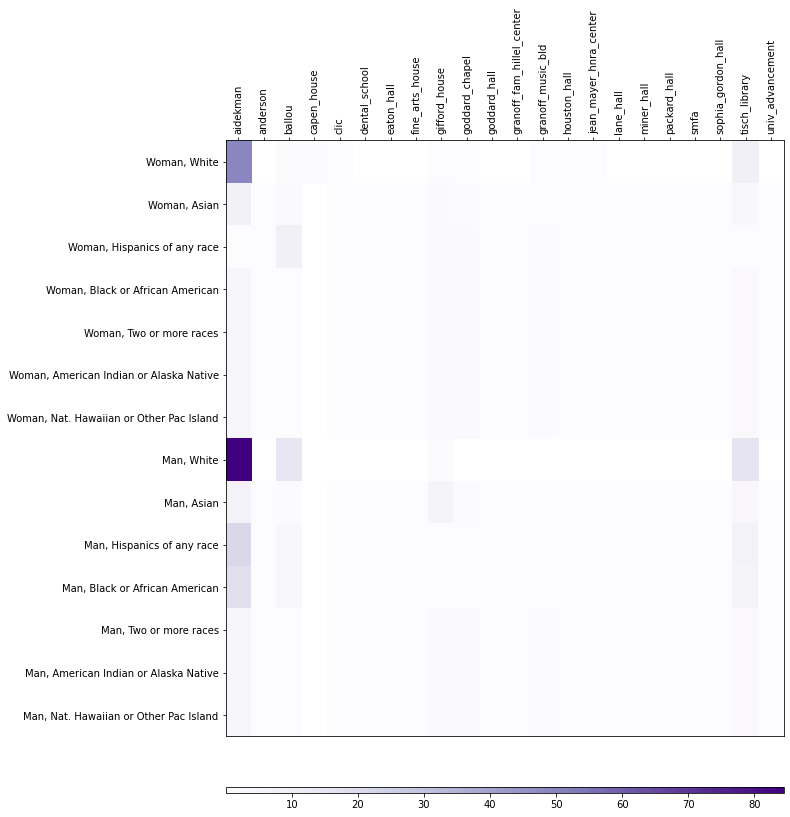

In [8]:
clipped_assignment_df = assignment_df.clip(upper = 1)
sc.assignment_heatmat(assignment_df)

## Validation

In [9]:
sc.baseline_average_value(category = "gender", in_group = "Man")

(12.450232610968145, 2.407847628316257)

In [10]:
sc.optimized_average_value(assignment_df, category = "gender", in_group = "Man")

(9.204648717453455, 5.576866264182442)

In [11]:
sc.baseline_average_value(category = "race", in_group = "White")

(13.260950905536497, 1.5623573876644954)

In [12]:
sc.optimized_average_value(assignment_df, category = "race", in_group = "White")

(7.315054906370855, 7.481557794889155)